In [9]:
import os
import sys
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
sys.path.append(os.path.join(os.getcwd(), 'common'))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.1
np.random.seed(seed=123)

# image = cv2.imread(img_path, 0)

In [10]:
def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))#NEED to convert to integeger, because we would be able to plot with real and complex number

    return mark, watermarked


# mark, watermarked = embedding(image, N, alpha, v)
# cv2.imwrite('watermarked.bmp', watermarked)

In [11]:
def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  csf = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(csf,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

# Plot the two images side by side
# plt.figure(figsize=(15, 6))
# plt.subplot(121)
# plt.title('Original')
# plt.imshow(image, cmap='gray')
# plt.subplot(122)
# plt.title('Watermarked')
# plt.imshow(watermarked,cmap='gray')
# plt.show()

# Compute quality
# psnr = cv2.PSNR(image, watermarked)
# print('PSNR: %.2fdB' % psnr)
# w = wpsnr(image, watermarked)
# print('wPSNR: %.2fdB' % w)


In [12]:
def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:mark_size+1]):
        if v=='additive':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
        elif v=='multiplicative':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
    return w_ex

# w_ex = detection(image, watermarked, alpha, N, v)

In [13]:
def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark_size, w):
    SIM = np.zeros(1000)
    for i in range(1, 1000):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('threshold: ', T)
    return T

# sim = similarity(mark, w_ex)
# T = compute_thr(sim, N, mark)

# if sim > T:
#     print('Mark has been found. SIM = %f' % sim)
# else:
#     print('Mark has been lost. SIM = %f' % sim)

## PIPELINE

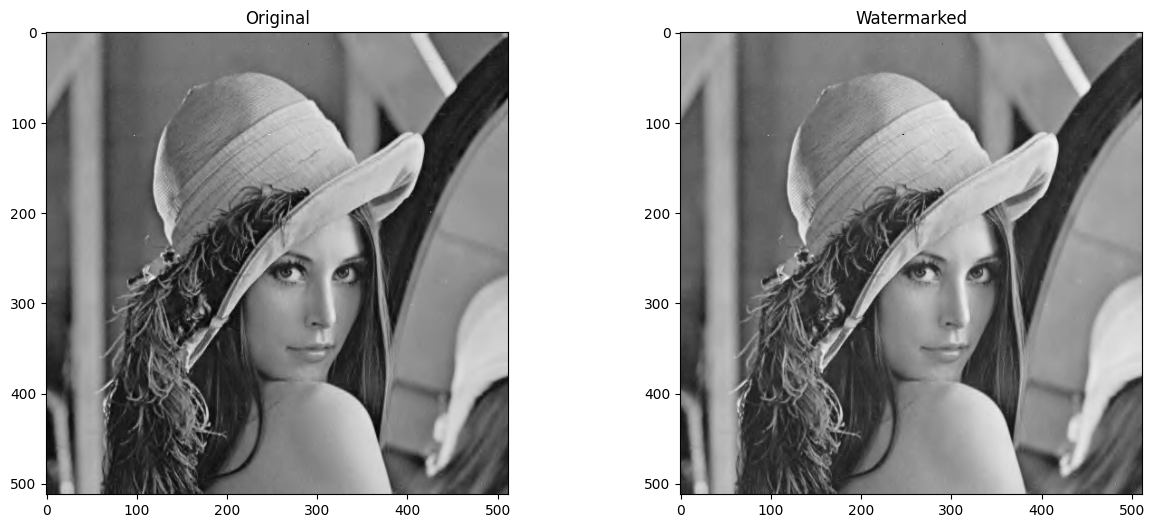

PSNR: 37.65dB
wPSNR: 44.20dB
threshold:  0.7155977263270926
Mark has been found. SIM = 0.997930


In [14]:


# load the image
image = cv2.imread(img_path, 0)

#Embed the watermark and save it
mark, watermarked = embedding(image, N, alpha, v)

#plot the original and watermarked image
cv2.imwrite('watermarked.bmp', watermarked)
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked,cmap='gray')
plt.show()

#check the quality of the watermarked image with respect to the original image
psnr = cv2.PSNR(image, watermarked)
print('PSNR: %.2fdB' % psnr)
w = wpsnr(image, watermarked)
print('wPSNR: %.2fdB' % w)


#Detect the watermark
w_ex = detection(image, watermarked, alpha, N, v)

#Compute the similarity and threshold
sim = similarity(mark, w_ex)
T = compute_thr(sim, N, mark)

if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)

## Attack

In [16]:

import importlib
import attacks 
from detection import detection, similarity

# Reload the entirea module, not the function
importlib.reload(attacks)

(history, best) = attacks.multiple_attacks(watermarked)
# print("history")
# print(history)




Applying AWGN:   0%|          | 0/6 [00:00<?, ?it/s]   

Applying JPEG Compression: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]

Best attack: JPEG Compression, PSNR: 38.25543938061093, WPSNR: 53.3482697244228, Params: QF: 57


In [17]:
alpha = 1.7
mark = np.load('ammhackati.npy')
for attack_name,attack in history.items():
    for attacked_image in attack:
        print("Attack: ", attacked_image['attacked_image'].shape,image.shape)
        w_ex = detection(image, attacked_image['attacked_image'], alpha)
        for w in w_ex:

            sim = similarity(mark, w)
            if sim > T:
                print('Mark has been found. SIM = %f' % sim)
                print("Attack: ", attack_name)
            else:
                print('Mark has been lost. SIM = %f' % sim)
                print("Attack: ", attack_name)

Attack:  (512, 512) (512, 512)


TypeError: 'NoneType' object is not iterable

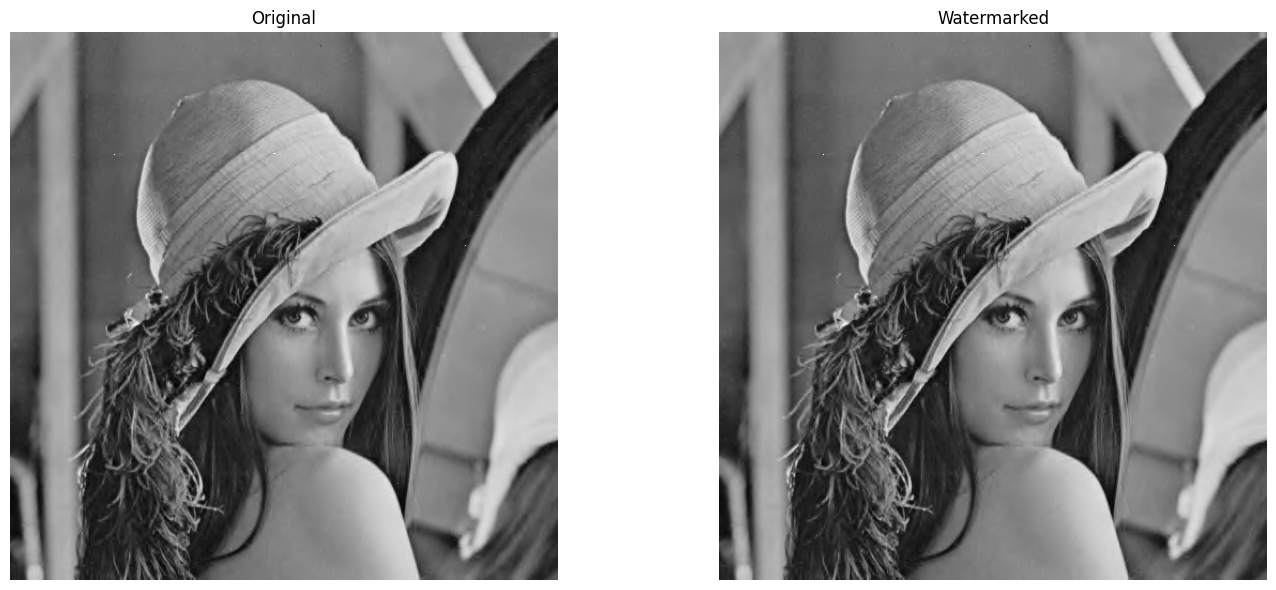

In [19]:
import pywt


def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask = compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband,axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            x = locations[idx][0]
            y = locations[idx][1]
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            x = locations[idx][0]
            y = locations[idx][1]
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
    
    return sign, watermarked

def recursive_embedding(coeffs, mark, alpha, level, max_level, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach level 3, embed the watermark and return
    if level == max_level:
        sign_LH, watermarked_LH = embed_watermark(LH, mark, level, 0, alpha, v)
        sign_HL, watermarked_HL = embed_watermark(HL, mark, level, 1, alpha, v)
        sign_HH, watermarked_HH = embed_watermark(HH, mark, level, 2, alpha, v)

        # Apply the sign and return the inverse DWT
        watermarked_LH *= sign_LH
        watermarked_HL *= sign_HL
        watermarked_HH *= sign_HH

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, level + 1, max_level, v)

    # Embed the watermark at this level
    sign_LH, watermarked_LH = embed_watermark(LH, mark, level, 0, alpha, v)
    sign_HL, watermarked_HL = embed_watermark(HL, mark, level, 1, alpha, v)
    sign_HH, watermarked_HH = embed_watermark(HH, mark, level, 2, alpha, v)

    # Apply the sign to the watermarked coefficients
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_level=2, v='multiplicative'):
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    
    # Start recursive embedding from level 0
    watermarked_image = recursive_embedding(coeffs, mark, alpha, level=0, max_level=max_level, v=v)
    
    return watermarked_image

alpha = 1.7
wm = embedding(image, mark, alpha)

from utility import visualize_images_with_desc
visualize_images_with_desc([image, wm], ['Original', 'Watermarked'])





In [20]:
import importlib
import attacks as attacks
from detection import detection, similarity

# Reload the entire module, not the function
importlib.reload(attacks)

(history, best) = attacks.multiple_attacks(wm)

Applying JPEG Compression: 100%|██████████| 6/6 [00:13<00:00,  2.27s/it]

Best attack: AWGN, PSNR: 46.937785294948426, WPSNR: 58.76737609326062, Params: std: 1


In [41]:
# alpha = 1.7
# mark = np.load('ammhackati.npy')
# for attack_name,attack in history.items():
#     for attacked_image in attack:
#         print("Attack: ", attacked_image['attacked_image'].shape,image.shape)
#         w_ex = detection(image, attacked_image['attacked_image'], alpha)
#         for w in w_ex:

#             sim = similarity(mark, w)
#             if sim > T:
#                 print('Mark has been found. SIM = %f' % sim)
#                 print("Attack: ", attack_name)
#             else:
#                 print('Mark has been lost. SIM = %f' % sim)
#                 print("Attack: ", attack_name)

Attack:  (512, 512) (512, 512)


ValueError: operands could not be broadcast together with shapes (1024,) (1023,) 

Applying JPEG Compression: 100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


Best attack: JPEG Compression, PSNR: 41.71730604026793, WPSNR: 59.755802249643395, Params: QF: 81
{'mean_psnr': 24.727436036076583, 'mean_wpsnr': 34.70058878119204, 'best_wpsnr': 59.755802249643395, 'worst_wpsnr': 11.652951278477603}


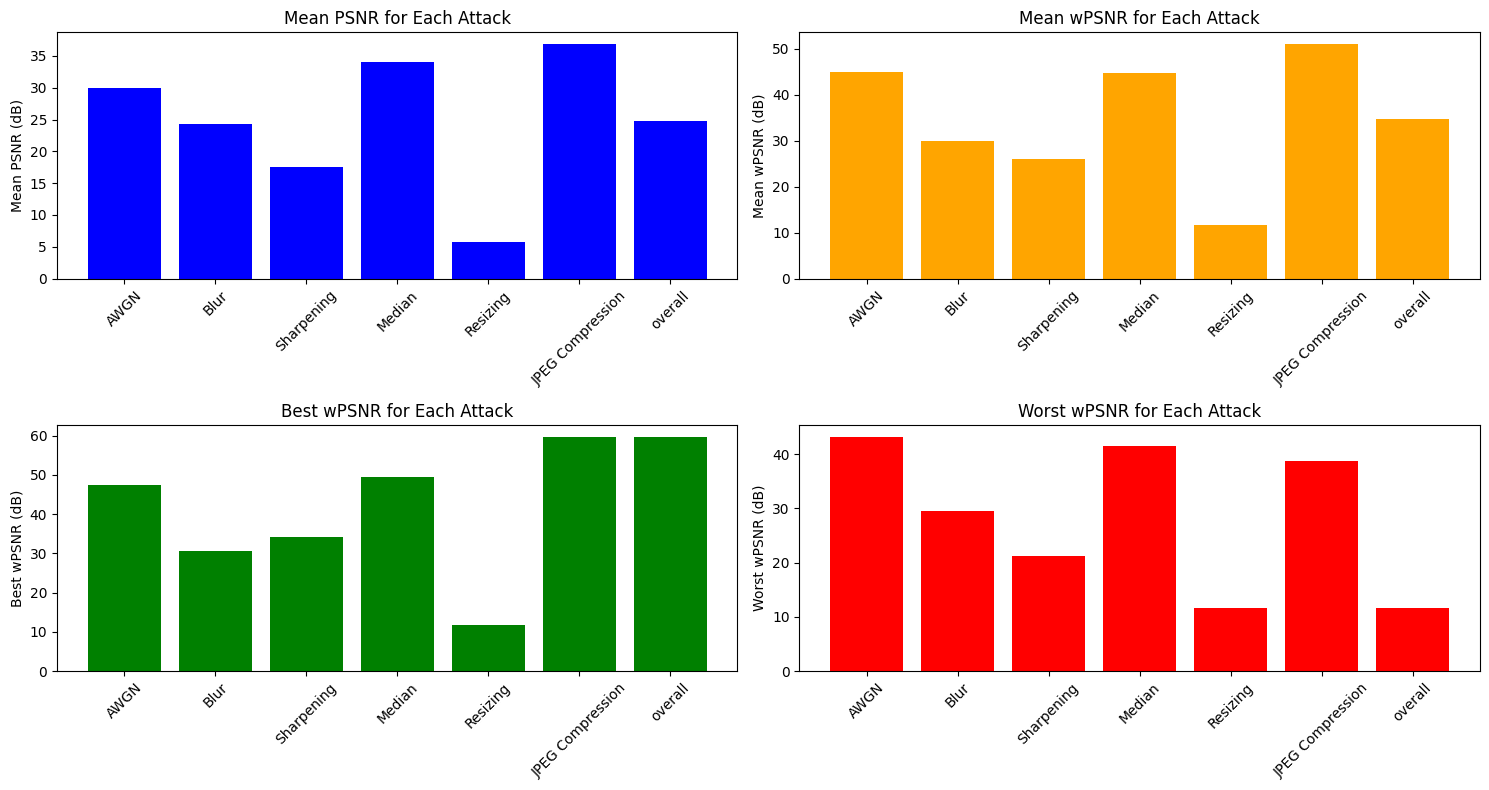

In [21]:


# Reload the entire module, not the function
importlib.reload(attacks)

(history,_) = attacks.multiple_attacks(wm)
#print(history)
stats = attacks.stats(history)
print(stats['overall'])
attacks.plot_stats(stats)